## - For the installation of FreeTrace, please run the cell below (this might take minutes depending on your internet speed).

In [ ]:
!pip install FreeTrace
import FreeTrace.installation

### - Once you installed the FreeTrace, you don't need to re-run the above cell again (you can delete the above cell to avoid the re-installation).

## - Installation of some additional pacakges for the visualisation in Jupyter notebook.

In [ ]:
!pip install requests ipykernel ipympl jupyter notebook ipython matplotlib ipywidgets scipy seaborn pillow numpy

## Load pacakges

In [ ]:
%matplotlib widget
import requests
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from PIL import Image
from matplotlib.patches import Rectangle
from module.fileIO.DataLoad import read_multiple_csv
from module.preprocessing import preprocessing, func_to_minimise, pdf_cauchy_1mixture, cauchy_location
from module.visuailzation import trajectory_visualization
try:
    from FreeTrace import Tracking, Localization
except:
    print("FreeTrace load failed")

## Sample video download

In [5]:
def download_file(url, save_path):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(save_path, 'wb') as file:
                file.write(response.content)
            print(f"File downloaded successfully: {save_path}")
        else:
            print(f"Failed to download file. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error: {e}")
        
fus = f"https://psilo.sorbonne-universite.fr/index.php/s/2YFgtzoctY5WfZW/download/sample1_mifibio.tiff"
h2b = f"https://psilo.sorbonne-universite.fr/index.php/s/xTRkLMPRj56ReW4/download/sample2_mifobio.tiff"
download_file(fus, f'./sample1_mifobio.tiff')
download_file(h2b, f'./sample2_mifobio.tiff')
if not os.path.exists('outputs'):
    os.mkdir('outputs')
if not os.path.exists('outputs/sample0'):
    os.mkdir('outputs/sample0')
if not os.path.exists('outputs/sample1'):
    os.mkdir('outputs/sample1')
if not os.path.exists('outputs/sample2'):
    os.mkdir('outputs/sample2')

File downloaded successfully: ./sample1_mifobio.tiff
File downloaded successfully: ./sample2_mifobio.tiff


#### sample0: Simulated fBm with (K, H) = {(0.4, 0.2), (1.5, 0.5), (1.5, 0.8)}, max_traj_length = 16 frames. </br>
#### sample1: FUS trajectories. Video length:2500 frames. Framerate:10ms. Pixelmicrons:160nm.</br>
#### sample2: H2B trajectories. Video length:2500 frames. Framerate:10ms. Pixelmicrons:160nm.</br>

# Requirements
FreeTrace requires Linux platform with GPU to infer fast the molecular trajectories.</br>
- CUDA accelerates the localisation of molecules from video if you have a NVIDIA GPU in your machine.</br>
- Cuda installation: [Nvidia Cuda installation](https://developer.nvidia.com/cuda-toolkit)</br>
  
You can run FreeTrace without a GPU; however, it'll be very slow if you try to infer the trajectories with fBm mode.</br>
Github: https://github.com/JunwooParkSaribu/FreeTrace

# 1. Parameter settings
Below is the parameters of FreeTrace.</br>

In [2]:
"""
Path of input video and output results.
"""
video_name = 'sample0_mifobio.tiff'  # input video.tiff path.
output_dir = 'outputs/sample0'  # output path.


"""
Basic parameters.
"""
window_size = 7  # Length (pixel) of sliding window to localise molecules from video
threshold = 0.5  # Threshold factor to determine the existence of a molecule inside sliding windows, base thresholds are calculated with SNR of images.
cutoff = 3  # Minimum length of trajectory for the output.


"""
Advanced parameters.
"""
gpu_for_localization = True  # GPU acceleration of localisation if True, False otherwise. (Only works with CUDA installation)
realtime_localization = False  # Real-time visualisation of localisation if True, False otherwise. (Only works in LINUX)
save_localization_video = False  # Save the visualised localisation in tiff format (Requires enough RAM for long video).

fBm_mode = True  # Tracking under fBm if True (slow). Otherwise, FreeTrace infers the trajectories under classical Brownian motion.
jump_threshold = None  # Maximum jump distance of molecules for 1 frame. If None, FreeTrace estimates it automatically with GMM.
graph_depth = 3  # Number of frames for the inference of trajectories at each step, between 1 and 5 inclusive. A higher number will slow down the speed.
realtime_tracking = False  # Real-time visualisation of tracking if True, False otherwise. (Only works in LINUX)
save_tracking_video = False  # Save the visualised trajectories in tiff format (Requires enough RAM for long video).

# 2. Localization

- Run the localization of molecules from video with pre-difined parameters above.</br>
- Localization.run_process() returns True if it finishes successfully.

In [3]:
success = Localization.run_process(input_video_path=video_name,
                                   output_path=output_dir,
                                   window_size=window_size,
                                   threshold=threshold,
                                   gpu_on=gpu_for_localization,
                                   save_video=save_localization_video,
                                   realtime_visualization=realtime_localization,
                                   verbose=1)


******************************** OPTIONS *****************************************
*********           Cuda: X, Localization without GPU (SLOW).            *********
**********************************************************************************



Localization: 100%|███████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 163.77frame/s]


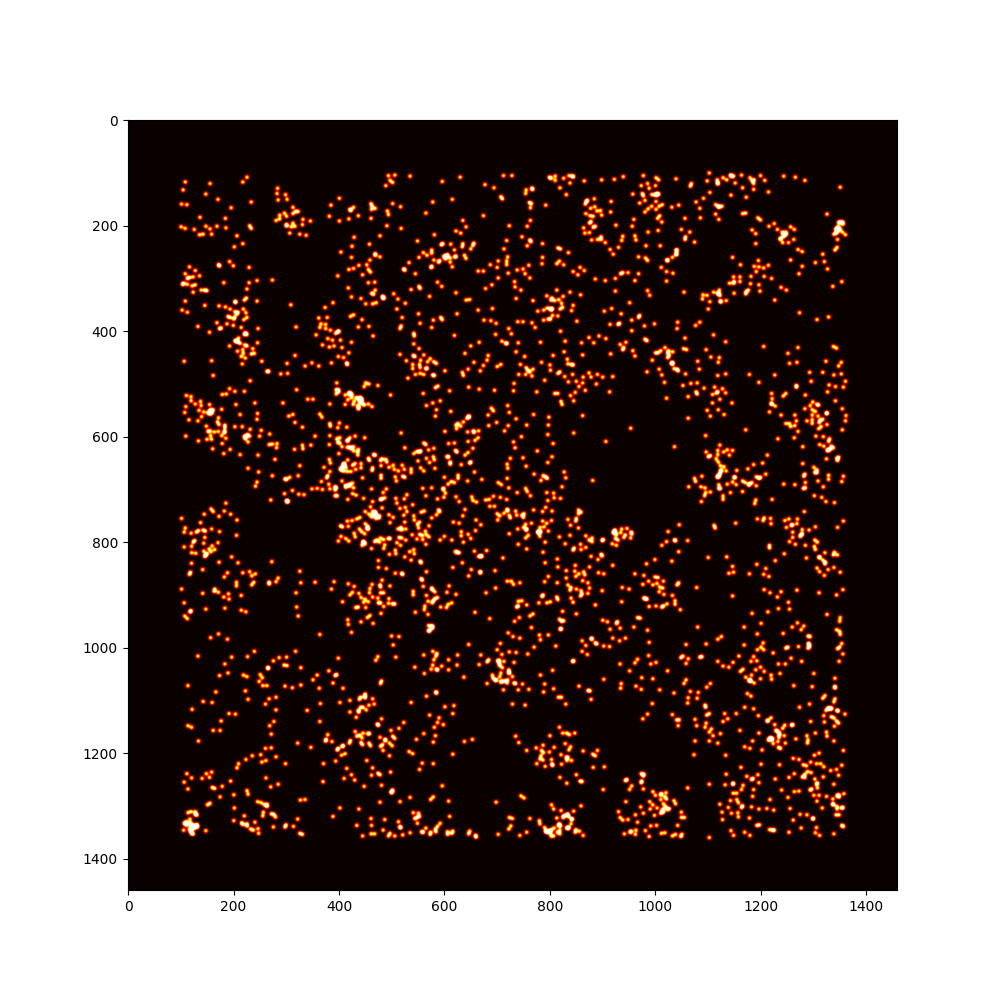

In [4]:
plt.close('all')
plt.figure(figsize=(10, 10))
plt.imshow(np.asarray(Image.open(f"{output_dir}/{video_name.split('.tif')[0]}_loc_2d_density.png")))
plt.show()

# 3. Trajectory inference

- Run the tracking of localized molecules from video and localization results, with pre-defined parameters above.</br>
- Tracking.run_process() returns True if it finishes successfully.

In [5]:
success = Tracking.run_process(input_video_path=video_name,
                               output_path=output_dir,
                               graph_depth=graph_depth,
                               cutoff=cutoff,
                               jump_threshold=jump_threshold,
                               gpu_on=fBm_mode,
                               save_video=save_tracking_video,
                               realtime_visualization=realtime_tracking,
                               verbose=1)

/Users/junwoo/venv/lib/python3.12/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(



******************************** OPTIONS *****************************************
*********       Tensorflow: O, Tracking with GPU if fBm_mode is ON.      *********
**********************************************************************************

Mean nb of particles per frame: 5.68 particles/frame


Tracking:   7%|█████                                                                | 37/501 [00:04<00:44, 10.52frame/s]/Users/junwoo/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Tracking: 100%|████████████████████████████████████████████████████████████████████| 501/501 [01:07<00:00,  7.47frame/s]


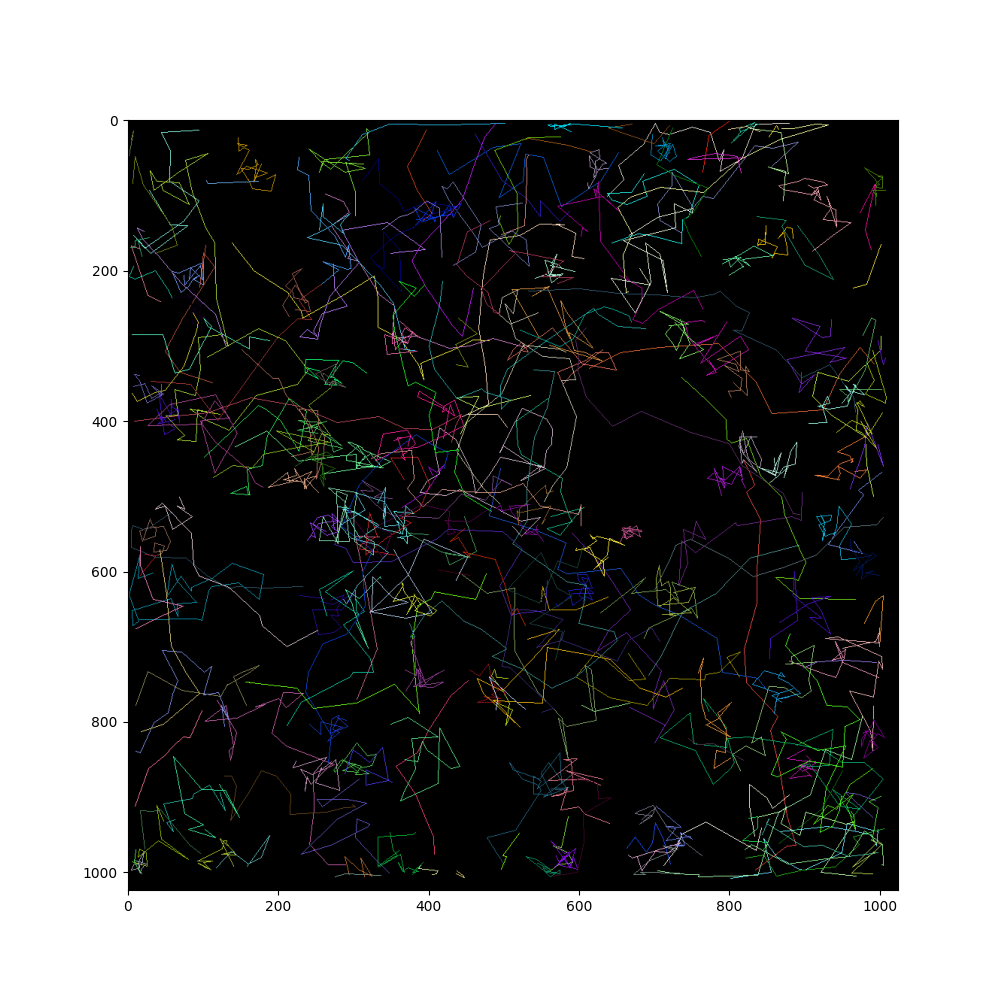

In [6]:
plt.close('all')
plt.figure(figsize=(10, 10))
plt.imshow(np.asarray(Image.open(f"{output_dir}/{video_name.split('.tif')[0]}_traces.png")))
plt.show()

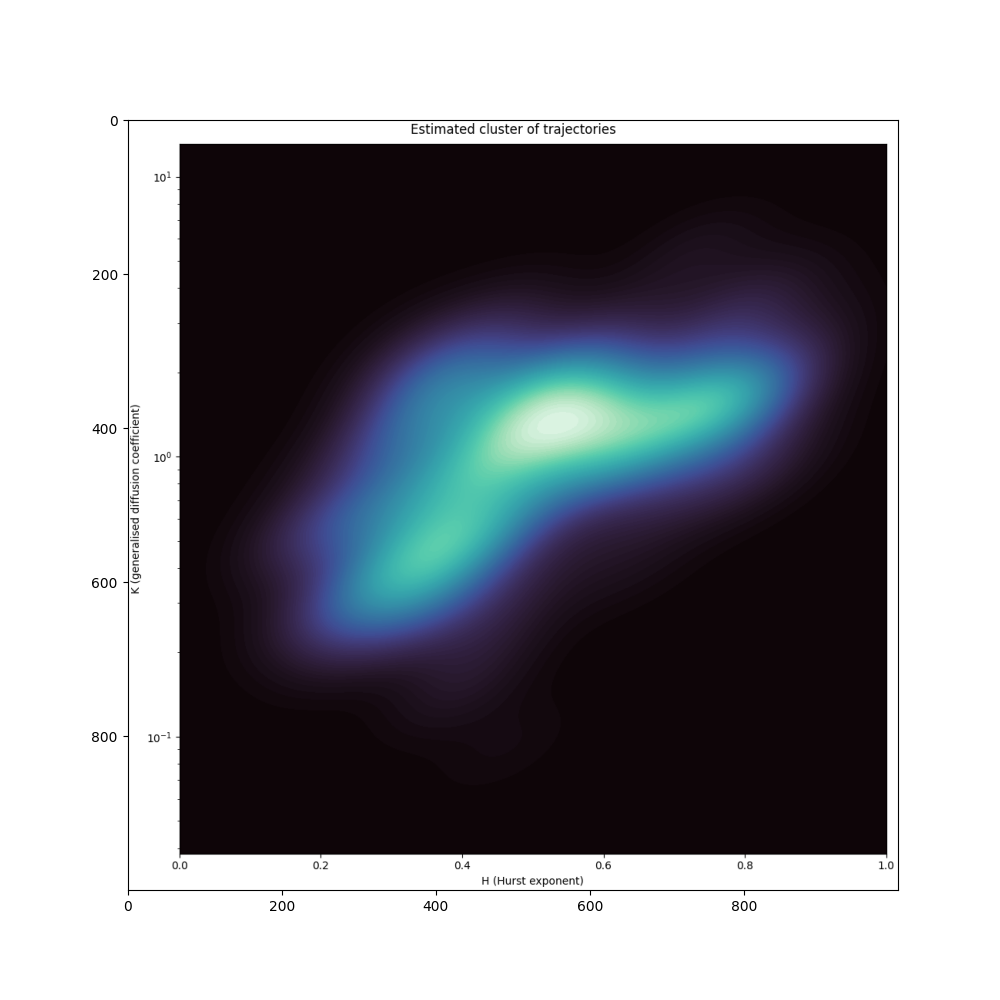

In [7]:
plt.close('all')
plt.figure(figsize=(10, 10))
plt.imshow(np.asarray(Image.open(f"{output_dir}/{video_name.split('.tif')[0]}_diffusion_distribution.png")))
plt.show()

# 4. Load trajectory data

In [11]:
"""
Options for the analysis, preprocessing of the trajectory data.
"""
FOLDER = f"outputs/sample0"  # The folder containing result .h5 files, condition2 contains samples of simulated fBm trajectories transitioning its states.
PIXELMICRONS = 1  # Length of pixel in micrometres. (0.16 -> the length of each pixel is 0.16 micrometre, it varies depending on the microscopy.)
FRAMERATE = 1  # Exposure time of video for each frame in seconds. (0.01 corresponds to the 10ms) 
CUTOFF = [3, 9999]   # Minimum length of trajectory for the analysis.



"""
Load trajectory data from a folder.
Very simple classification: filtering of the trajectory on the H-K space.
"""
original_data = read_multiple_csv(path=FOLDER) # all trajectories

"""
Predefined filters for sample0 (Simulation).
"""
#original_data = original_data[(original_data['H'] < 0.7) & (original_data['K'] > 0.6)] # group 1 (Brownian)
#original_data = original_data[(original_data['H'] < 0.4) & (original_data['K'] < 0.6)] # group 2 (subidffusive)
#original_data = original_data[(original_data['H'] > 0.7) & (original_data['K'] > 0.6)] # group 3 (superdiffusive)

"""
Predefined filters for sample1 (FUS).
"""
#original_data = original_data[(original_data['K'] > 0.5)] # group 1
#original_data = original_data[(original_data['H'] < 0.42) & (original_data['K'] < 0.5)] # group 2
#original_data = original_data[(original_data['H'] > 0.42) & (original_data['K'] < 0.5)] # group 3

"""
Predefined filters for sample2 (H2B).
"""
#original_data = original_data[(original_data['K'] < 0.25)] # group 1
#original_data = original_data[(original_data['K'] > 0.25)] # group 2



"""
Preprocessing generates 7 data.
@params: data folder path, pixelmicrons, framerate, cutoff
@output: DataFrame, DataFrame, ndarray, networkx graph, DataFrame, DataFrame, list, dict

Preprocessing includes the following steps.
1. Exclude the trajectory where the length is shorter than CUTOFF.
2. Convert from pixel unit to micrometre unit with PIXELMICRONS and FRAMERATE.
3. Generate 5 DataFrames. 
To calculate tamsd, set it to True. It defaults to off since tamsd takes time to calculate it.
"""
analysis_data1, analysis_data2, analysis_data3, analysis_data4, analysis_data5, _, _, _, tamsd, _, _ \
    = preprocessing(data=original_data, pixelmicrons=PIXELMICRONS, framerate=FRAMERATE, cutoff=CUTOFF, div_time_gap=True, tamsd_calcul=True)
trajectory_image, legend_patch, cmap_for_graph, cmap_for_plot = trajectory_visualization(original_data, analysis_data1, CUTOFF, PIXELMICRONS, resolution_multiplier=40, roi='')
tamsd = tamsd.dropna()


** Computing of Ensemble-averaged TAMSD takes a few minutes **


Analysis: 100%|██████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 289.89trajectory/s]
/Users/junwoo/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

** preprocessing finished **
** visualizing trajectories... **


Visualization: 100%|████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 1738.60trajectory/s]


### From here, we process the data to create plots or print results.<br>
Data is stored as<br>
1. analysis_data1: (DataFrame: contains data of mean_jump_distance, K, H, duration, traj_id)<br>
2. analysis_data2: (DataFrame: contains data of 2D displacements)<br>
3. analysis_data3: (DataFrame: contains data of angles)<br>
4. analysis_data4: (DataFrame: contains data of 1D displacements)<br>
5. analysis_data5: (DataFrame: contains data of Ratios)<br>
6. tamsd: (DataFrame: contains ensemble-averaged tamsd for each state.) <br>
<br>
Units: <br>
K: Generalised diffusion coefficient, px^2 / frame^2H.<br>
H: Hurst exponent (2 x anomalous diffusion exponent), real number between 0 and 1, exclusive.<br>

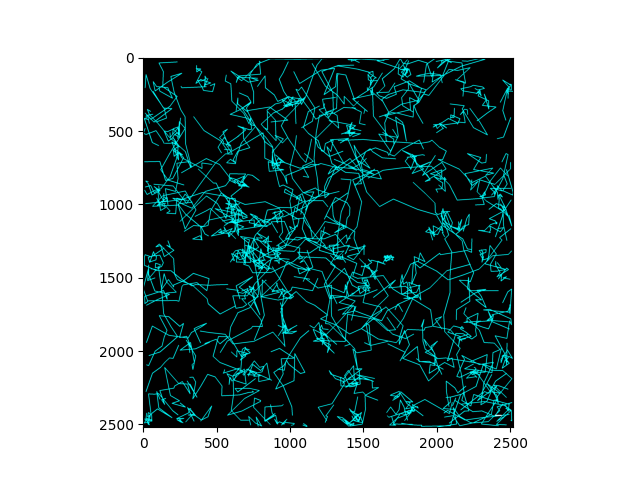

In [12]:
#p0: Trajectory image.
plt.close('all')
plt.figure(f'p0')
plt.imshow(trajectory_image)
plt.show()

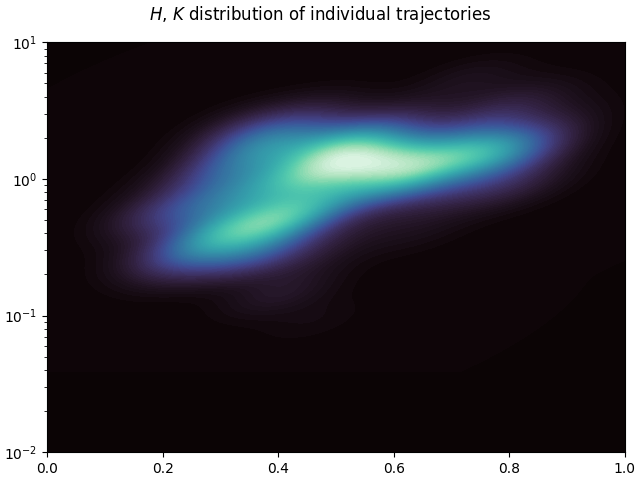

In [13]:
#p1: Distribution of H(x-axis) and K(y-axis)
plt.close('all')
fig, axs = plt.subplots(1, 1, layout='constrained', num=f'p1')
colormap = sns.color_palette("mako", as_cmap=True)
axs.add_patch(Rectangle((0, -100), 1.0, 1000, ec='none', fc=colormap(0), zorder=0))
sns.kdeplot(
    data=analysis_data1, x="H", y="K", fill=True, ax=axs, thresh=0, levels=100, cmap=colormap, log_scale=(False, True), bw_adjust=1.0,
)
axs.set_yscale('log')
axs.set_xlim([0.0, 1.0])
axs.set_ylim([10**-2, 10**1])
axs.set(xlabel=None, ylabel=None)
fig.suptitle(r'$H$, $K$ distribution of individual trajectories')
plt.show()

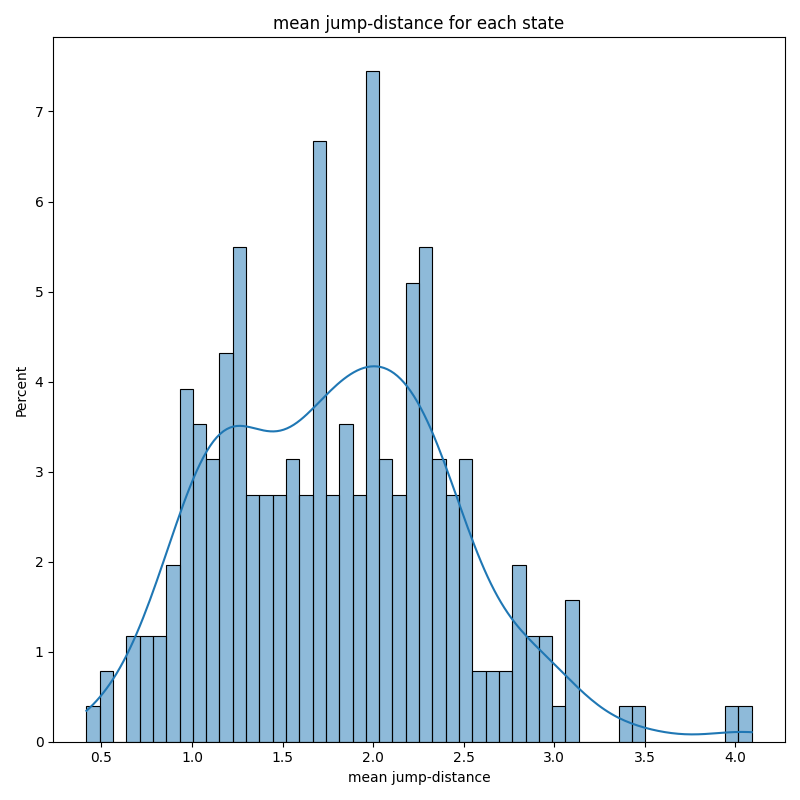

In [14]:
#p2: Histogram with kde(kernel density estimation) plot of mean jump distances.
plt.close('all')
plt.figure(f'p2', figsize=(8, 8))
p2 = sns.histplot(analysis_data1, x=f'mean_jump_d', stat='percent', bins=50, kde=True)
p2.set_xlabel(r'mean jump-distance')
p2.set_title(f'mean jump-distance for each state')
plt.tight_layout()
plt.show()

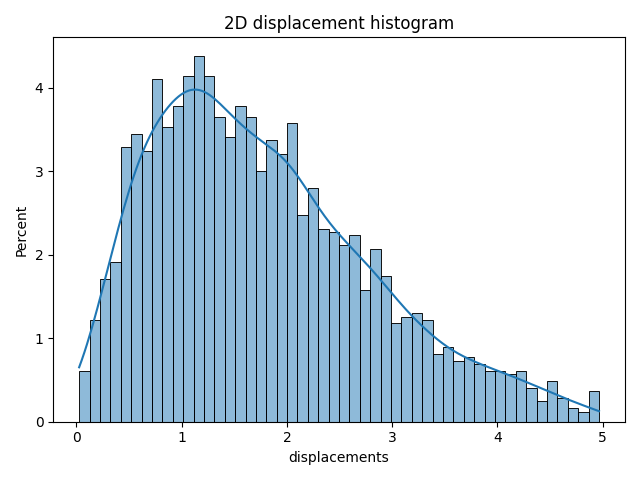

In [15]:
#p3: 2D Displacement histogram
plt.close('all')
fig, axs = plt.subplots(num='p3')
p3 = sns.histplot(data=analysis_data2, x='displacements', stat='percent', bins=50, kde=True)
p3.set_title(f'2D displacement histogram')
plt.tight_layout()
plt.show()

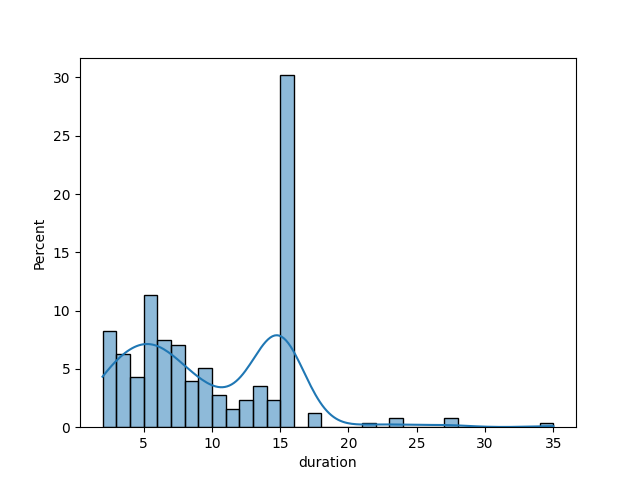

In [16]:
#p4: trajectory length(sec) histogram
plt.close('all')
fig, axs = plt.subplots(num=f'p4')
p4 = sns.histplot(data=analysis_data1, x='duration', stat='percent', binwidth=1, kde=True)
plt.show()

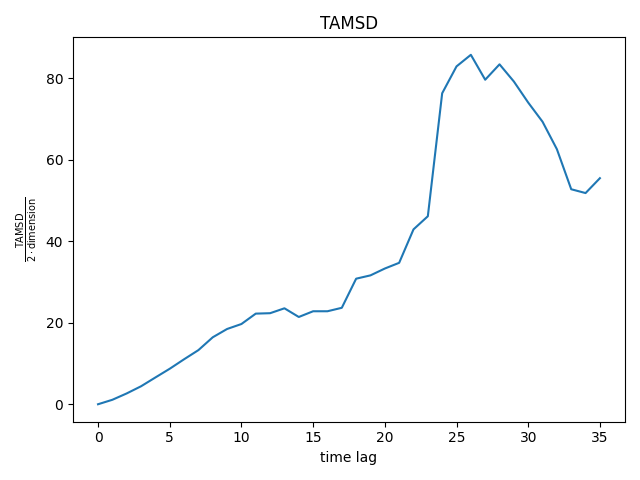

In [17]:
#p5: TAMSD
plt.close('all')
plt.figure(f'p5')
p5 = sns.lineplot(data=tamsd, x=tamsd['time'], y=tamsd['mean'])
p5.set_title(f'TAMSD')
p5.set_xlabel(r'time lag')
p5.set_ylabel(r'$\frac{\text{TAMSD}}{\text{2} \cdot \text{dimension}}$')
plt.tight_layout()
plt.show()

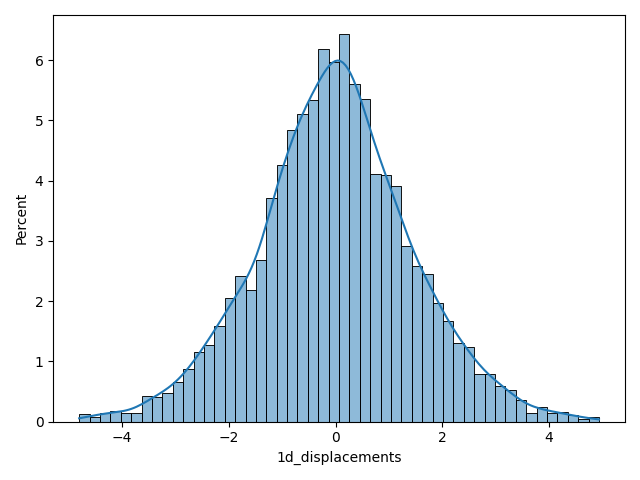

In [18]:
#p6: 1D displacements histogram
plt.close('all')
plt.figure(num=f'p6')
p6 = sns.histplot(data=analysis_data4, x='1d_displacements', stat='percent', bins=50, kde=True)
plt.tight_layout()
plt.show()

## Cauchy fitting for the estimation of H at the ensemble level.

Estimated H: 0.554785141374904, Residual: 0.00021339852659698776


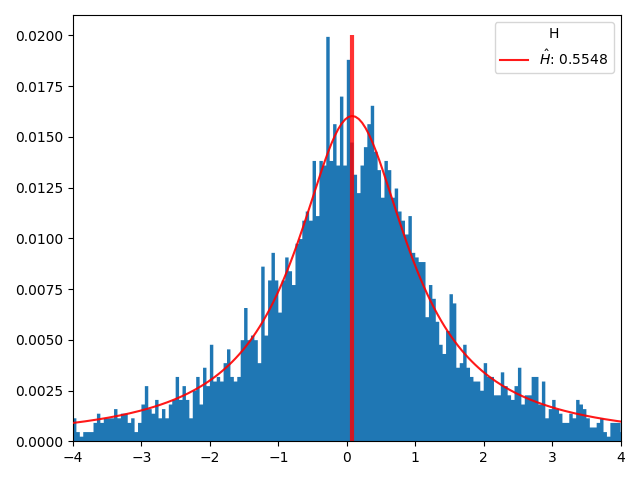

In [19]:
plt.close('all')
plt.figure(num=f'p7')
vline_ymax = 0.020
hist_bins = np.arange(-1000, 1000, 0.05)
target = analysis_data5['ratios'].to_numpy() 
hist, bin_edges = np.histogram(target, bins=hist_bins, density=False)
plt.hist(bin_edges[:-1], bin_edges, weights=hist/np.sum(hist), histtype='stepfilled', zorder=0, linewidth=2)
xs = hist_bins[:-1] + (hist_bins[1] - hist_bins[0])/2
cons = ({'type': 'ineq', 'fun': lambda k:  k[2] - 0.2},
        #{'type': 'eq', 'fun': lambda k:  k[0] + k[1] + k[2] - 1},
        )
res1 = minimize(func_to_minimise, x0=[0.5, 0.1], args=(pdf_cauchy_1mixture, xs, hist/np.sum(hist)), 
                method='trust-constr',
                #constraints=cons, 
                bounds=((1e-6, 0.9999), (1e-6, None),),
                )
params, residual = res1.x, res1.fun
print(f"Estimated H: {params[0]}, Residual: {residual}")
plt.vlines(cauchy_location(params[0]), ymin=0, ymax=vline_ymax, colors='red', alpha=0.8, zorder=1, linewidth=3)
plt.plot(xs, pdf_cauchy_1mixture(xs, *params), c='red',
            label=r'$\hat{H}$: %5.4f' % params[0], alpha=0.9, zorder=20)
plt.xlim([-4, 4])
plt.legend(title=r'H', loc='upper right')
plt.tight_layout()
plt.show()

## Video information:
#### sample0: Simulated fBm with (K, H) = {(0.4, 0.2), (1.5, 0.5), (1.5, 0.8)}, max_traj_length = 16 frames. </br>
#### sample1: FUS trajectories. Video length:2500 frames. Framerate:10ms. Pixelmicrons:160nm.</br>
#### sample2: H2B trajectories. Video length:2500 frames. Framerate:10ms. Pixelmicrons:160nm.</br>

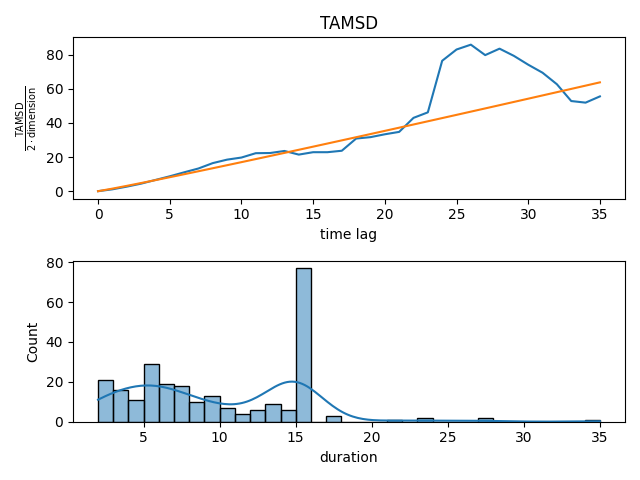

In [20]:
#p8: TAMSD with y=kx^2H
K_to_plot = 1.5
H_to_plot = 0.5272
curve = lambda K, H, tau:K*tau**(2*H)

plt.close('all')
fig, axs = plt.subplots(2, 1, num=f'p8')
sns.lineplot(data=tamsd, x=tamsd['time'], y=tamsd['mean'], ax=axs[0])
axs[0].plot(tamsd['time'], curve(K_to_plot, H_to_plot, tamsd['time'].to_numpy()))
axs[0].set_title(f'TAMSD')
axs[0].set_xlabel(r'time lag')
axs[0].set_ylabel(r'$\frac{\text{TAMSD}}{\text{2} \cdot \text{dimension}}$')
sns.histplot(data=analysis_data1, x='duration', stat='count', binwidth=1, kde=True, ax=axs[1])
plt.tight_layout()
plt.show()